# Pierwsze komórki są testami, późniejsze rezultaty są niżej

In [31]:
import os
import fiona
import rasterio
import rasterio.mask
import numpy as np

name = 'Swiebodzin'
path = os.path.join(os.getcwd(),name)

shapes = fiona.open(os.path.join(path,'bufor_obszar_'+name.lower()+'.shp'))


In [22]:
[len(l) for l in shapes[0]['coordinates']]

[16, 1, 1, 1, 1, 1]

In [65]:
shape = shapes[0]['geometry']['coordinates'][1][0]

In [67]:
x = np.array([a[0] for a in shape])
y = np.array([a[1] for a in shape])
x_mean = x.mean()
y_mean = y.mean()
x_max = np.abs(x-x_mean).max()
y_max = np.abs(y-y_mean).max()


2959
16304
89
22231


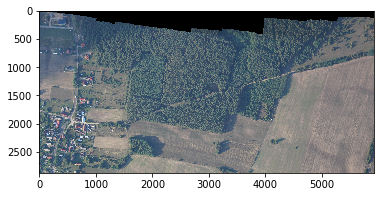

In [77]:
import matplotlib.pyplot as plt

with rasterio.open(os.path.join(path,'RGB_'+name+'.tif')) as tif_handler:
    row_start, col_start = tif_handler.index(x_mean-x_max, y_mean-y_max)
    row_stop, col_stop = tif_handler.index(x_mean+x_max, y_mean+y_max)
    print(row_start)
    print(col_start)
    print(row_stop)
    print(col_stop)
    win = rasterio.windows.Window.from_slices((row_stop, row_start), (col_start, col_stop))
    img = np.moveaxis(np.stack([tif_handler.read(i+1, window=win) for i in range(3)]),0,-1)
    plt.imshow(img)

In [73]:
img.shape

(2870, 5927)

In [78]:
from osgeo import gdal

driver = gdal.GetDriverByName('GTiff')
filename = os.path.join(path,'RGB_'+name+'.tif')


def get_pixel_based_on_lon_lat(tif, points_list):
    band = tif.GetRasterBand(1)

    cols = tif.RasterXSize
    rows = tif.RasterYSize

    transform = tif.GetGeoTransform()

    xOrigin = transform[0]
    yOrigin = transform[3]
    pixelWidth = transform[1]
    pixelHeight = -transform[5]

    data = band.ReadAsArray(0, 0, cols, rows)

    rows = []
    cols = []
    for point in points_list:
        cols.append(int((point[0] - xOrigin) / pixelWidth))
        rows.append(int((yOrigin - point[1]) / pixelHeight))

    return cols, rows



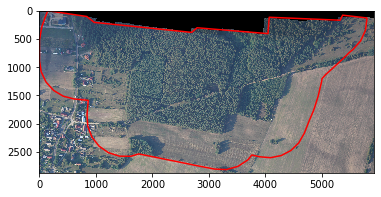

In [86]:

joint = [tif_handler.index(l[0], l[1]) for l in shape]
x = np.array([l[0] for l in joint])
x = x - x.min()
y = np.array([l[1] for l in joint])
y = y - y.min()
plt.imshow(img)
plt.plot(y,x, color='r')

In [2]:
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive
from shapely.geometry import shape
import matplotlib.pyplot as plt
import os
import fiona
import rasterio
import rasterio.mask
import numpy as np
import cv2


def initiate_geoms(shp):
    if shp['type'] == 'Polygon':
        return shp['coordinates']
    else:
        return [poly[0] for poly in shp['coordinates']]

    
    
name = 'Swiebodzin'
path = os.path.join(os.getcwd(),name)

shapes = fiona.open(os.path.join(path,'obszar_'+name.lower()+'.shp'))



In [17]:
shapes[0]

{'type': 'Feature',
 'id': '0',
 'properties': OrderedDict([('id_ob', 721),
              ('id_adres', 1420016057),
              ('adr_les', '14-20-2-13-359A  -    -'),
              ('pow', 39.53),
              ('oddz', '359A')]),
 'geometry': {'type': 'Polygon',
  'coordinates': [[(246787.5765571584, 491391.4736039958),
    (246645.07730671292, 491390.5542539929),
    (246625.5176858866, 491441.0832744609),
    (246359.832836329, 491398.7040960041),
    (246355.2241989116, 491397.6825938961),
    (246352.88, 491512.22),
    (246351.82, 491557.15),
    (246351.5, 491570.66),
    (246351.35, 491577.03),
    (246350.72999999998, 491603.22),
    (246348.44, 491699.63),
    (246347.97, 491719.58),
    (246347.91999999998, 491721.6),
    (246350.28, 491743.85),
    (246355.41, 491792.13),
    (246356.66, 491853.5),
    (246658.95, 491763.85),
    (246661.75, 491707.23),
    (246662.32, 491695.79),
    (246662.75, 491681.41),
    (246665.33000000002, 491594.59),
    (246672.53999999998, 4

In [68]:
@interact(i=(0,len(shapes)-1,1))
def plot_shape(i):
    single_shape = shapes[i]
    shp = initiate_geoms(single_shape['geometry'])
    print(single_shape['properties'])
    with rasterio.open(os.path.join(path,'RGB_'+name+'.tif')) as tif_handler:
        x = np.array([a[0] for poly in shp for a in poly])
        y = np.array([a[1] for poly in shp for a in poly])
        row_start, col_start = tif_handler.index(x.min(), y.min())
        row_stop, col_stop = tif_handler.index(x.max(), y.max())
        win = rasterio.windows.Window.from_slices((row_stop, row_start), (col_start, col_stop))
        img = np.stack([tif_handler.read(i+1, window=win) for i in range(3)])
        mask = np.zeros(img.shape[1:],dtype=np.uint8)
        for poly in shp:
            joint = [tif_handler.index(l[0], l[1]) for l in poly]
            joint = np.array([[[l[1]-col_start, l[0]-row_stop] for l in joint]], dtype=np.int32)
            cv2.fillPoly(mask, pts =[joint], color= 255)
        masked = cv2.bitwise_and(img,img,mask = np.stack([mask,mask,mask]))
        plt.imshow(np.moveaxis(masked,0,-1))
        

interactive(children=(IntSlider(value=110, description='i', max=220), Output()), _dom_classes=('widget-interac…

# Segmentacja chorych drzew

In [25]:
from forest_iterator_class import ForestIterator
import os
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive
from shapely.geometry import shape
import matplotlib.pyplot as plt
import fiona
import rasterio
import rasterio.mask
import numpy as np
import cv2
name = 'Swiebodzin'
path = os.path.join(os.getcwd(),name)

shape_path = os.path.join(path,'obszar_'+name.lower()+'.shp')
rgb_path = os.path.join(path,'RGB_'+name+'.tif')
nir_path = os.path.join(path,'NIR_'+name+'.tif')
it = ForestIterator(rgb_path,nir_path,shape_path)

In [31]:
#163
@interact(i=(0,len(shapes)-1,1))
def plot_shape(i=163):
    data = it[i]
    rgb = data['rgb']
    nir = data['nir']
    
    #NDVI Thresholding
    ret, mask_nir = cv2.threshold(nir, 0.20, 1, cv2.THRESH_BINARY_INV)
    kernel = np.ones((11,11),np.uint8)
    mask_nir = cv2.morphologyEx(mask_nir, cv2.MORPH_OPEN, kernel)
    mask_nir = cv2.morphologyEx(mask_nir, cv2.MORPH_CLOSE, kernel)
    mask_nir = np.uint8(mask_nir)
    rgb_mask_nir = np.stack([mask_nir,mask_nir,mask_nir])
    masked_rgb = cv2.bitwise_and(rgb,rgb,mask=rgb_mask_nir)
    
    #Red Thresholding
    ret, mask_r = cv2.threshold(masked_rgb[0,:,:],70 ,255 ,cv2.THRESH_BINARY)
    mask_r = cv2.morphologyEx(mask_r, cv2.MORPH_OPEN, kernel)
    mask_r = cv2.morphologyEx(mask_r, cv2.MORPH_CLOSE, kernel)
    mask_r = np.uint8(mask_r)
    rgb_mask_r = np.stack([mask_r,mask_r,mask_r])
    masked_rgb = cv2.bitwise_and(masked_rgb,masked_rgb,mask=rgb_mask_r)
    
    #Printing
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(12,12))
    fig.suptitle('Segmentation')
    fig.tight_layout()
    ax1.imshow(np.moveaxis(data['rgb'],0,-1))
    ax2.imshow(nir, cmap='gray')
    ax3.imshow(np.moveaxis(masked_rgb,0,-1))
    ax4.imshow(mask_nir)

interactive(children=(IntSlider(value=163, description='i', max=220), Output()), _dom_classes=('widget-interac…